In [1]:
import query_bayern_fahrplan as q
import pandas as pd
from tqdm import tqdm
import numpy as np
from datetime import datetime, timedelta, date, time
import re
import itertools
import more_itertools
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [8, 6]
plt.rcParams['figure.dpi'] = 80
plt.rcParams['figure.facecolor'] = 'white'

In [7]:
next_monday = date.today()
while next_monday.weekday() != 0: next_monday = next_monday + timedelta(days=1)

start_dt = datetime.combine(next_monday, time(8, 0))
end_dt = datetime.combine(next_monday, time(12, 0))

In [8]:
departures = []
#stations = ["Sanderglacisstraße", "Rathaus", "Neubaustraße", "Barbarossaplatz"]
stations = ["Sanderring", "Rathaus", "Neubaustraße", "Barbarossaplatz"]
for station in stations:
    print(station)
    dep = q.departures_by_datetime_range(q.stations[station], start_dt, end_dt)
    departures.extend([(x.time,  x.line_data['tripCode'], x.destination, x.line, station, x) for x in dep])

Sanderring
request for 2022-06-13 08:00:00
13.06.2022 08:20
request for 2022-06-13 08:20:00
13.06.2022 08:39
request for 2022-06-13 08:39:00
13.06.2022 09:02
request for 2022-06-13 09:02:00
13.06.2022 09:20
request for 2022-06-13 09:20:00
13.06.2022 09:42
request for 2022-06-13 09:42:00
13.06.2022 10:05
request for 2022-06-13 10:05:00
13.06.2022 10:27
request for 2022-06-13 10:27:00
13.06.2022 10:49
request for 2022-06-13 10:49:00
13.06.2022 11:12
request for 2022-06-13 11:12:00
13.06.2022 11:34
request for 2022-06-13 11:34:00
13.06.2022 11:57
request for 2022-06-13 11:57:00
13.06.2022 12:19
Rathaus
request for 2022-06-13 08:00:00
13.06.2022 08:28
request for 2022-06-13 08:28:00
13.06.2022 08:58
request for 2022-06-13 08:58:00
13.06.2022 09:28
request for 2022-06-13 09:28:00
13.06.2022 10:04
request for 2022-06-13 10:04:00
13.06.2022 10:37
request for 2022-06-13 10:37:00
13.06.2022 11:13
request for 2022-06-13 11:13:00
13.06.2022 11:49
request for 2022-06-13 11:49:00
13.06.2022 12:22
N

In [9]:
df = pd.DataFrame(departures, columns=['time', 'tripCode', 'destination', 'line', 'station', 'obj'])
df = df[df.line.isin(['1', '10', '114', '14', '214', '3', '4', '5'])]


def filter_departures(x):
    if x.station == 'Neubaustraße':
        return x.destination in ['Heuchelhof', 'Sanderau', 'Rottenbauer', 'Würzburg Fechenbachstraße']
    if x.station == 'Rathaus':
        return x.destination in ['Grombühl Uni-Kliniken', 'Zellerau', 'Hauptbahnhof', 'Würzburg Bürgerbräu', 'Würzburg, Hauptbahnhof West', 'Würzburg Pestalozzistraße']
    return True

df = df[df.apply(filter_departures, axis=1)]

trips = []

for obj in tqdm(df.obj):
    seq = obj.stop_sequence()
    t = [(stop.station, stop.departure) for stop in seq[:1]] + [(stop.station, stop.arrival) for stop in seq[1:]]
    trips.append(t)
    
df['trip'] = trips
#df.to_pickle('./table.pkl')

100%|██████████████████████████████████████████████████████████████| 368/368 [01:55<00:00,  3.18it/s]


In [3]:
#df = pd.read_pickle('./table.pkl')

In [11]:
#with pd.option_context('display.max_rows', None, 'display.max_columns', None):
#    display(df[df.station == 'Neubaustraße'])

In [12]:
df_new = df.groupby(['line', 'tripCode']).first().reset_index()

stops = {'Würzburg Sanderglacisstraße': 2, 
         'Würzburg Sanderring': 2, 
         'Würzburg Am Hubland': 4.4, 
         'Würzburg Barbarossaplatz': 0,
         'Würzburg Hubland/Mensa': 4.4,
         'Würzburg Juliuspromenade': 0, 
         'Würzburg Rathaus': .8, 
         'Wü Philosophisches Institut': 3.7,
         'Würzburg Neubaustraße': 1.2,
         'Würzburg Mathematisches Instit': 5.1,
         'Würzburg Bibliothekszentrum': 5.8
         #'Würzburg Mainfranken Theater': 2.8
        }

new_rows = []
new_trips = []

for i, row in df_new.iterrows():
    line = row['line']
    trip = row['trip']
    s = [t[0] for t in trip]
    if 'Würzburg Rathaus' in s:
        if s.index('Würzburg Neubaustraße') < s.index('Würzburg Sanderring'):
            trip = trip[s.index('Würzburg Neubaustraße'):s.index('Würzburg Sanderring')+1]
            #if trip[-1][1].split(':')[1] in ['46', '16', '32', '02']:
            #    continue
        elif 'Würzburg Juliuspromenade' in s:
            trip = trip[s.index('Würzburg Rathaus'):s.index('Würzburg Juliuspromenade')+1]
            #if trip[-1][1].split(':')[1] in ['18', '48', '33', '41', '11', '02', '03']:
            #    continue
        else:
            continue
    if line == '10':
        trip = list(trip)
        if 'Würzburg Bibliothekszentrum' in s:
            trip = trip[:s.index('Würzburg Bibliothekszentrum')+1]
        else:
            continue
        trip.pop(s.index('Würzburg Am Hubland'))
    if line == '14':
        if 'Würzburg Sanderglacisstraße' in s:
            trip = list(trip)
            trip.pop(s.index('Würzburg Am Hubland'))
            trip.pop(s.index('Würzburg Sanderring'))
            #print(trip)
    
        
    trip = [(t[0], datetime.strptime(t[1], '%H:%M')) for t in trip if t[0] in stops.keys()]
    
    if trip[0][1] <= datetime.strptime('07:45', '%H:%M') or trip[-1][1] >= datetime.strptime('14:15', '%H:%M'): continue
    if len(trip) < 2: continue
    
    new_trips.append(trip)
    new_rows.append(i)

df_new = df_new.loc[new_rows]
df_new['formattedTrip'] = new_trips

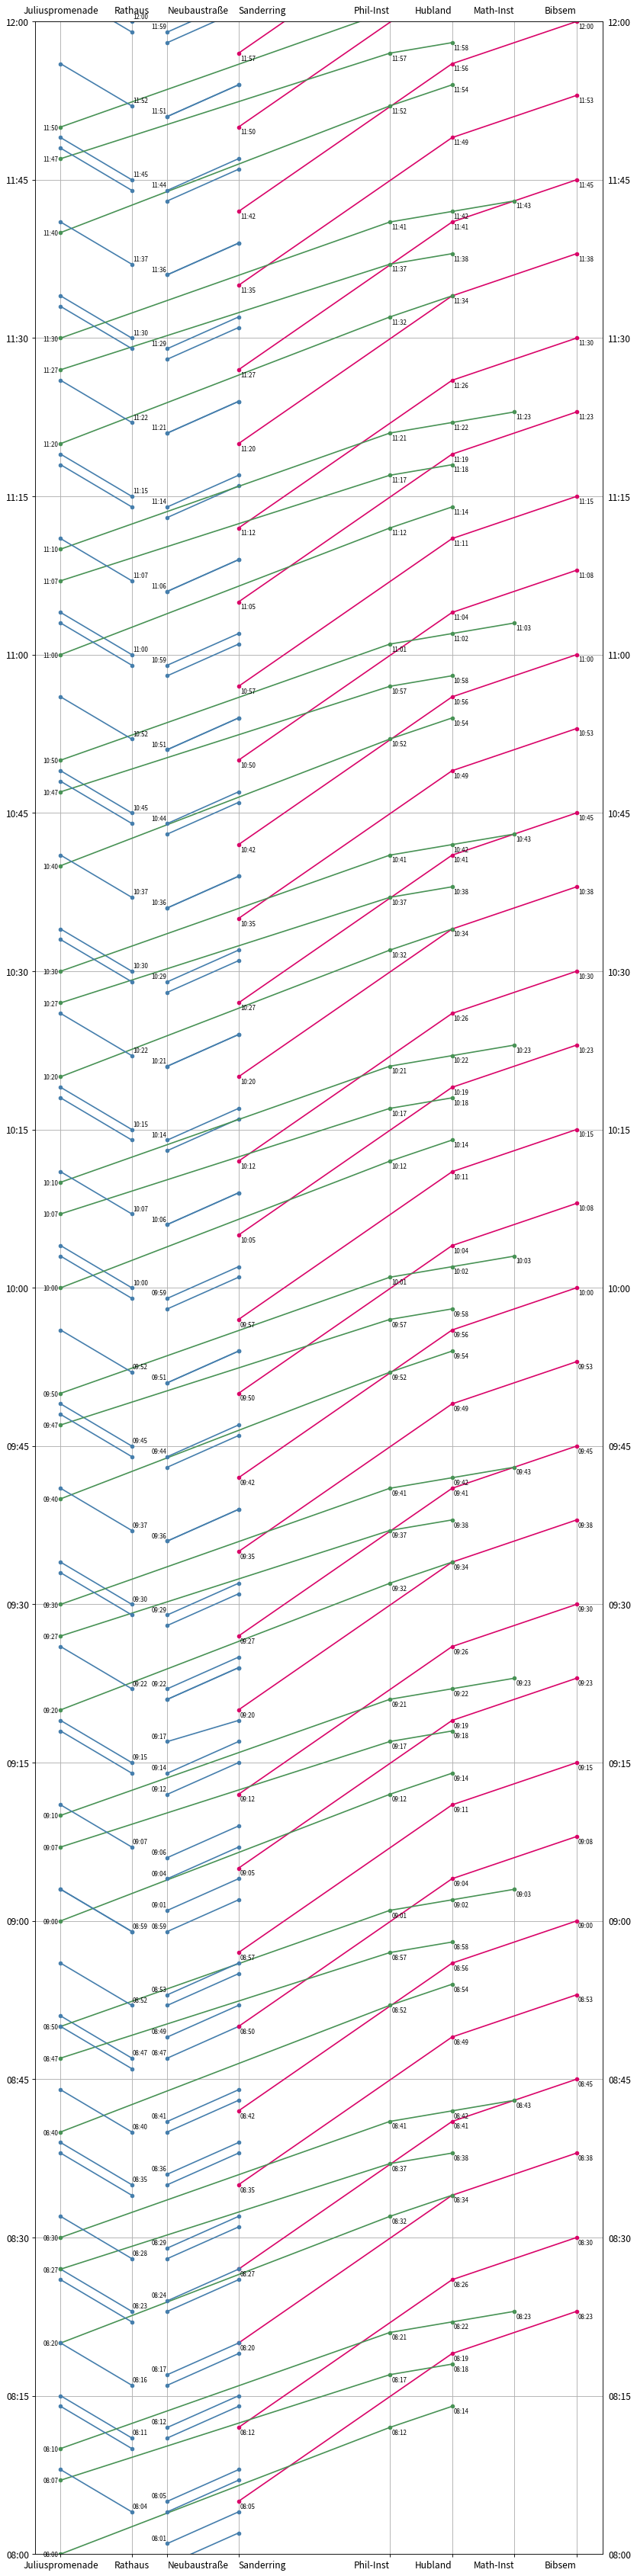

In [14]:
stoplabels = {'Würzburg Sanderglacisstraße': 'Sanderring', 
         'Würzburg Sanderring': 'Sanderring', 
         'Würzburg Am Hubland': 'Hubland', 
         'Würzburg Barbarossaplatz': 'Juliuspromenade',
         'Würzburg Hubland/Mensa': 'Hubland',
         'Würzburg Juliuspromenade': 'Juliuspromenade', 
         'Würzburg Rathaus': 'Rathaus', 
         'Wü Philosophisches Institut': 'Phil-Inst',
         'Würzburg Neubaustraße': 'Neubaustraße',
         'Würzburg Mathematisches Instit': 'Math-Inst',
         'Würzburg Mainfranken Theater': 'Theater',
         'Würzburg Bibliothekszentrum': 'Bibsem'
             }
linecolor = {'10': '#D90368', '1': '#457EAC', '3': '#457EAC', '4': '#457EAC', '5': '#457EAC', '14': '#489255', '114': '#489255', '214': '#489255'}

plt.rcParams.update({'font.size': 8, 'xtick.labelsize': 12, 'ytick.labelsize': 12, 'lines.markersize': 4})
plt.rcParams["font.family"] = "Source Sans Pro"
#fig, ax = plt.subplots(figsize=(12, 55))
fig, ax = plt.subplots(figsize=(12, 55))

for _, row in df_new.iterrows():
    X = [ stops[s[0]] for s in row.formattedTrip ]
    Y = [ s[1] for s in row.formattedTrip ]
    line = row.line
    #if pd.isnull(row.wait) or row.wait.to_pytimedelta() > timedelta(minutes=4): 
    #    ax.plot(X, Y, 'o-', color='red', alpha=0.3)
    #    continue
    
    ax.plot(X, Y, 'o-', color=linecolor[line])
    
for v in set(stops.values()):
    if v not in [stops['Würzburg Barbarossaplatz'], stops['Würzburg Rathaus'], stops['Würzburg Neubaustraße'], stops['Würzburg Sanderring']]:
        for i in set([d for s, d in itertools.chain.from_iterable(df_new.formattedTrip.values) if stops[s] == v]):
            ax.annotate(i.strftime('%H:%M'), (v, i), (2, -2), ha='left', va='top', textcoords='offset points')
    else:
        datelabels = sorted(trip[0][1] for trip in df_new.formattedTrip.values if stops[trip[0][0]] == v)
        textargs = {'ha': 'left', 'va': 'bottom', 'xytext': (1, 2)}
        if v == stops['Würzburg Neubaustraße']:
            textargs = {'ha': 'right', 'va': 'bottom', 'xytext': (-1, 2)}
        if v == stops['Würzburg Rathaus']:
            textargs = {'ha': 'left', 'va': 'bottom', 'xytext': (1, 2)}
        if v == stops['Würzburg Barbarossaplatz']:
            textargs = {'ha': 'right', 'va': 'center_baseline', 'xytext': (-3, 0)}
        if v == stops['Würzburg Sanderring']:
            textargs = {'ha': 'left', 'va': 'top', 'xytext': (2, -2)}
        for labelgrp in more_itertools.split_when(datelabels, lambda a, b: b-a  > timedelta(seconds=60)):
            ax.annotate(labelgrp[-1].strftime('%H:%M'), (v, labelgrp[-1]), textcoords='offset points', **textargs)

        
ticks, labels = zip(*[ (v, '\n'.join(set([stoplabels[k] for k, vv in stops.items() if vv == v ]))) for v in set(stops.values()) ])
ax.set_xticks(ticks)
ax.set_xticklabels(labels)
#ax.set_ylim((datetime.strptime('7:45', '%H:%M'), datetime.strptime('14:15', '%H:%M')))
ax.set_ylim((datetime.strptime('08:00', '%H:%M'), datetime.strptime('12:00', '%H:%M')))
import matplotlib.dates as mdates
ax.yaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax.yaxis.set_major_locator(mdates.MinuteLocator(interval=15))
ax.grid()
#ax.invert_yaxis()
ax.tick_params(labeltop=True, labelright=True)

ticklabels = ax.get_xticklabels()
for l in ticklabels:
    if l.get_text() in {'Neubaustraße', 'Sanderring'}:
        l.set_ha('left')
    elif l.get_text() in {'Juliuspromenade', 'Rathaus'}:
        l.set_ha('center')
    else:
        l.set_ha('right')

    
#plt.savefig('timetable.pdf', bbox_inches='tight', dpi=300)